In [1]:
! pip3 -q install optax equinox

In [2]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
   7c3b304..29a697e  main       -> origin/main
Updating 7c3b304..29a697e
Fast-forward
 misc/Chebyshev.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [3]:
import jax.numpy as jnp
from jax import random, jit, config, vmap
from functools import partial
config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [4]:
from datasets import generate_dataset

# Lorenz system

The infamous system of equations

\begin{equation}
\begin{split}
\frac{dx}{dt} &= \sigma (y - x), \\
\frac{dy}{dt} &= x (\rho - z) - y, \\
\frac{dz}{dt} &= x y - \beta z.
\end{split}
\end{equation}

with default value of parameters $\sigma = 10$, $\beta = 8/3$, $\rho = 28$.

In [5]:
@jit
def F(u, t, sigma=10, beta=8/3, rho=28):
    return jnp.stack([sigma*(u[1]-u[0]), u[0]*(rho-u[2])-u[1], u[0]*u[1]-beta*u[2]], -1)

N_points, N_intervals, N_sweeps, N_aa = 2**5 + 1, 200, 40, 10
T = [0, 100]

@jit
def inv_dF(u, u_F, t, h, sigma=10, beta=8/3, rho=28, t1=T[1]/N_intervals, t0=T[0]):
    h_ = h*(t1 - t0)/2
    A = jnp.array([
        [1 + h_*sigma, -h_*sigma, 0],
        [h_*(u[2]-rho), 1 + h_, u[0]*h_],
        [-u[1]*h_, -u[0]*h_, 1 + beta*h_]
    ])
    return jnp.linalg.solve(A, u_F)

u0 = jnp.array([27.0, -8.0, 8.0])

First we generate trajectories using SDC, and AA.

In [6]:
Euler, Sol, Time, Res_sdc, Res_aa = generate_dataset.generate_trajectory(u0, F, None, T, N_points, N_intervals, N_sweeps, N_aa)

In [7]:
Sol.shape

(200, 33, 3)

In [8]:
u0 = jnp.array([4.0, 7.0, 8.0])
Euler, Sol, Time, Res_sdc, Res_aa = generate_dataset.generate_trajectory(u0, F, None, T, N_points, N_intervals, N_sweeps, N_aa)

In [9]:
Sol.shape

(200, 33, 3)

In [10]:
jnp.vstack([Sol, Sol]).shape

(400, 33, 3)

In [11]:
S_, T_ = generate_dataset.recompute_on_uniform_grid(Sol, Time)
solution, time = generate_dataset.glue_trajectory(S_, T_);

## Solution and convenience functions

The solution is on the Chebyshev grid. One may want to reinterpolate on the uniform grid first.

In [12]:
S, T = generate_dataset.recompute_on_uniform_grid(Sol, Time)

Trajectory generated above come in chunks.

In [13]:
S.shape

(200, 33, 3)

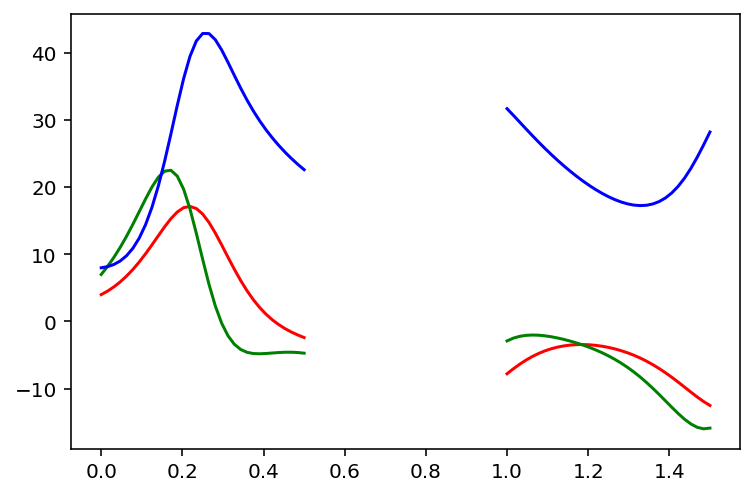

In [14]:
for i, c in enumerate(["red", "green", "blue"]):
  plt.plot(T[0], S[0, :, i], color=c)
  plt.plot(T[2], S[2, :, i], color=c);

We can glue those chunks.

In [15]:
solution, time = generate_dataset.glue_trajectory(S, T);

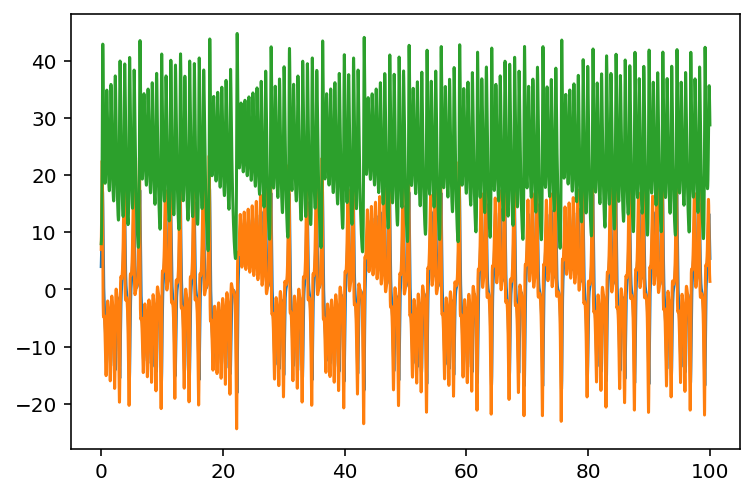

In [16]:
plt.plot(time, solution);

Attractor is usually more recognizable.

In [17]:
from mpl_toolkits.mplot3d import Axes3D

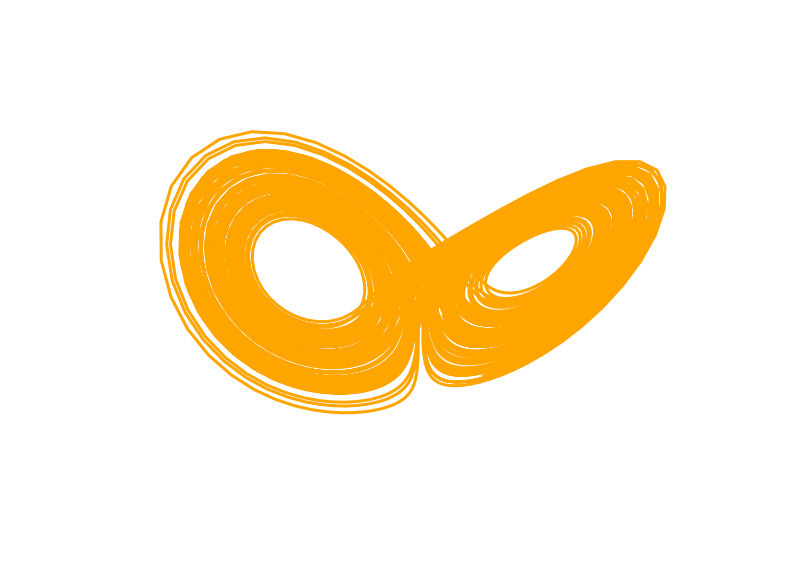

In [18]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(solution[:9000, 0], solution[:9000, 1], solution[:9000, 2], color="orange")
ax.axis("off");

## Convergence plots and their analysis

Convergence plots of AA and SDC iterations are below.

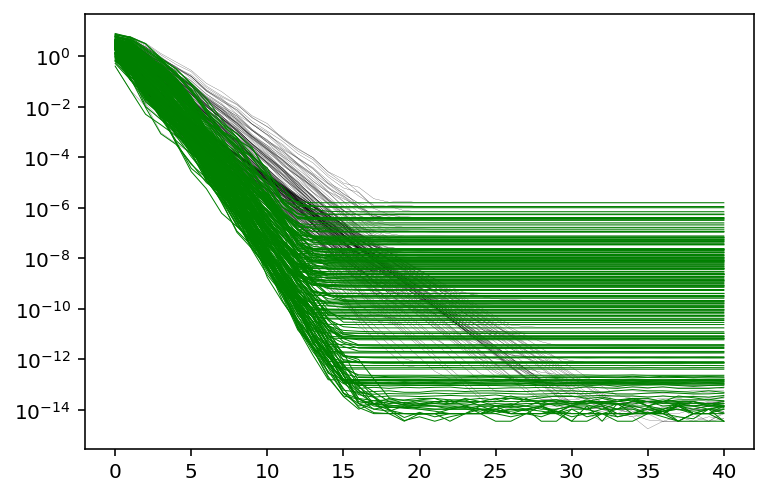

In [19]:
plt.yscale("log")
plt.plot(Res_sdc, color="black", linewidth=0.1)
plt.plot(Res_aa, color="green", linewidth=0.5);

Is would be useful to find saturation points for both types of iteration. We can achieve that solving a few related linear regression problems.

In [20]:
from misc import utils

In [21]:
y = utils.preprocess_trajectory(Res_sdc[:, 0])
x = jnp.arange(len(y))
M = utils.breaking_point(x, y)

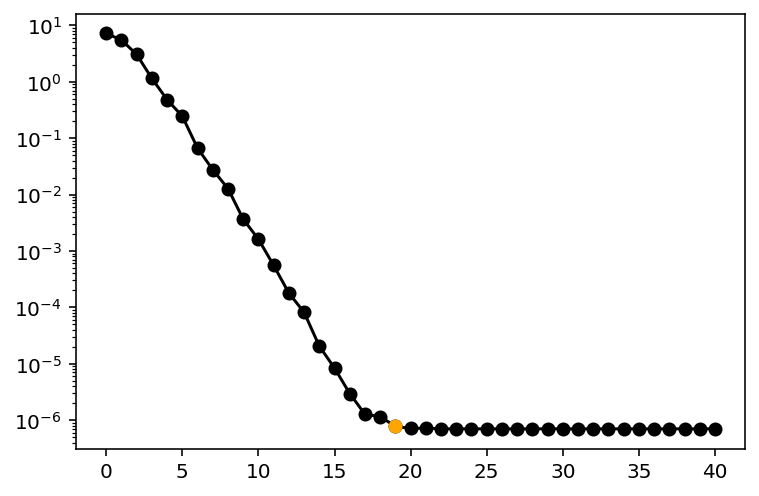

In [22]:
plt.yscale("log")
plt.plot(Res_sdc[:, 0], "o-", color="black")
plt.plot(M, Res_sdc[M, 0], "o", color="orange");

The same way we can find breaking points for all convergence plots and find relative differences between the numbers of iterations needed for saturation.

In [23]:
Deltas = []
x = jnp.arange(len(utils.preprocess_trajectory(Res_aa[:, 0])))

for i in range(Res_sdc.shape[1]):

  N = [utils.breaking_point(x, utils.preprocess_trajectory(y)) for y in [Res_sdc[:, i], Res_aa[:, i]]]
  delta = (N[0] - N[1]) / N[0]

  Deltas.append(delta)

Deltas = jnp.hstack(Deltas) * 100

Here are those relative differences (percentage of improvement) with a little jitter added to them.

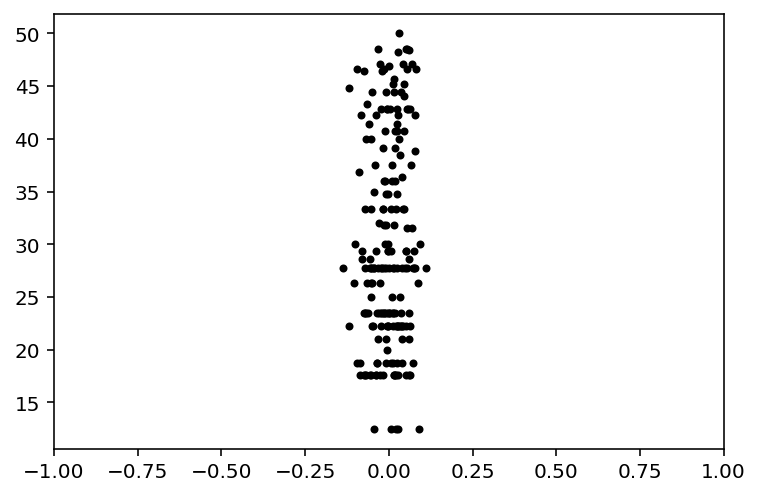

In [24]:
jitter = 0.5*1e-1*random.normal(random.PRNGKey(13), [len(Deltas),])
plt.plot(jnp.zeros(len(Deltas)) + jitter, Deltas, ".", color="black");
plt.xlim([-1, 1]);

And here is the histogram.

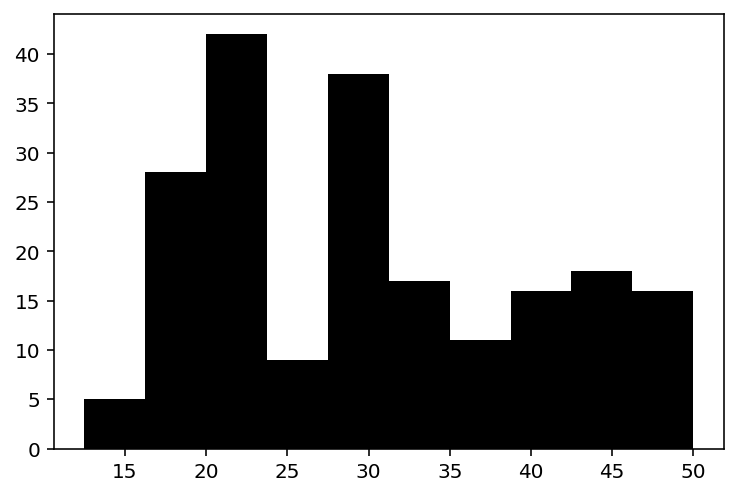

In [25]:
plt.hist(Deltas, color="black");

# Van der Pol equation

In [26]:
eps = 0.01

N_points, N_intervals, N_sweeps, N_aa = 2**5 + 1, 200, 60, 10
T = [0, 40]

u0 = jnp.array([1.0, 2.0])

@jit
def F(u, t, epsilon=eps):
    return jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1)

@jit
def inv_dF(u, u_F, t, h, epsilon=eps, t1=T[1]/N_intervals, t0=T[0]):
    h_ = h*(t1 - t0)/2
    det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
    u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
    u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
    return jnp.stack([u0, u1], -1)

In [27]:
Euler, Sol, Time, Res_sdc, Res_aa = generate_dataset.generate_trajectory(u0, F, inv_dF, T, N_points, N_intervals, N_sweeps, N_aa)

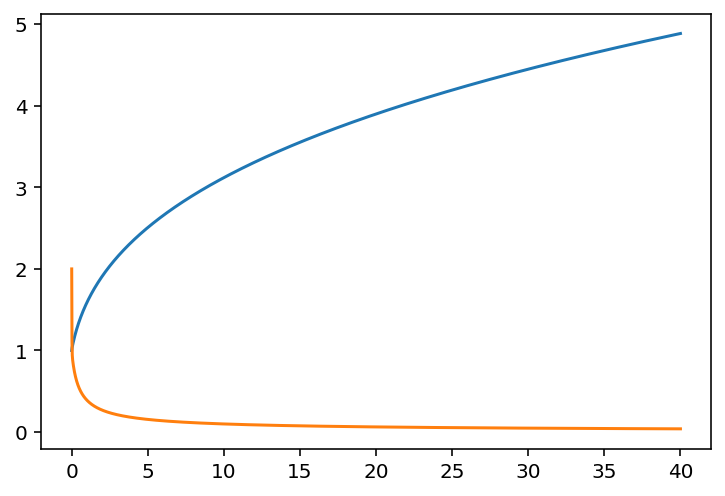

In [28]:
S, T = generate_dataset.recompute_on_uniform_grid(Sol, Time)
solution, time = generate_dataset.glue_trajectory(S, T)
plt.plot(time, solution);

## Convergence plots and their analysis

Convergence plots for Van der Pol equation provides example when my code for the detection of breaking points fails miserably.

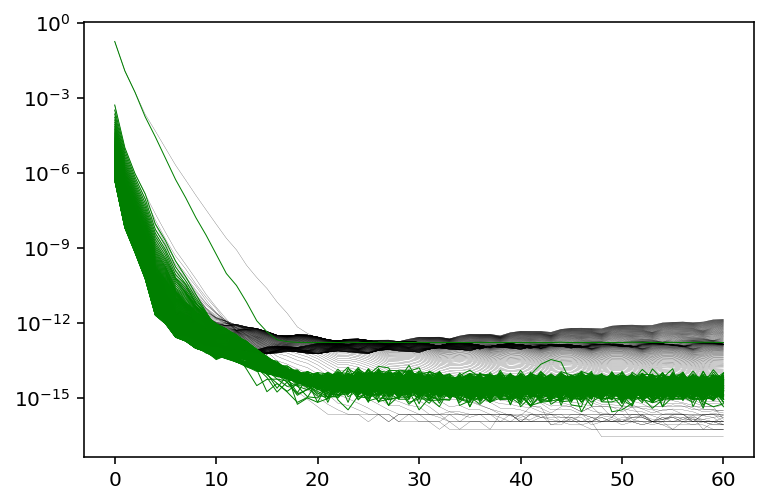

In [29]:
plt.yscale("log")
plt.plot(Res_sdc, color="black", linewidth=0.1)
plt.plot(Res_aa, color="green", linewidth=0.5);

In [30]:
Deltas = []
x = jnp.arange(len(utils.preprocess_trajectory(Res_aa[:, 0])))

for i in range(Res_sdc.shape[1]):

  N = [utils.breaking_point(x, utils.preprocess_trajectory(y)) for y in [Res_sdc[:, i], Res_aa[:, i]]]
  delta = (N[0] - N[1]) / N[0]

  Deltas.append(delta)

Deltas = jnp.hstack(Deltas) * 100

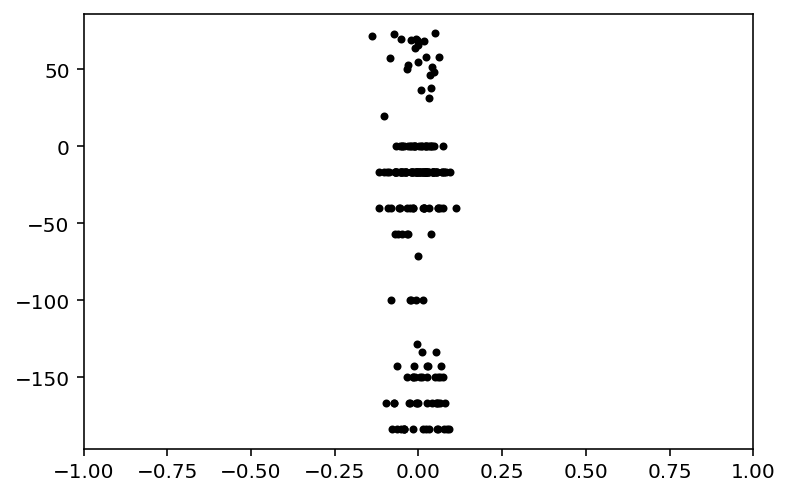

In [31]:
jitter = 0.5*1e-1*random.normal(random.PRNGKey(13), [len(Deltas),])
plt.plot(jnp.zeros(len(Deltas)) + jitter, Deltas, ".", color="black");
plt.xlim([-1, 1]);

In [32]:
Bad_trajectories_aa = Res_aa[:, Deltas < 0]
Bad_trajectories_sdc = Res_sdc[:, Deltas < 0]

In [33]:
utils.breaking_point(x, utils.preprocess_trajectory(Bad_trajectories_aa[:, 0]))

DeviceArray(17, dtype=int64)

In [34]:
utils.breaking_point(x, utils.preprocess_trajectory(Bad_trajectories_sdc[:, 0]))

DeviceArray(7, dtype=int64)

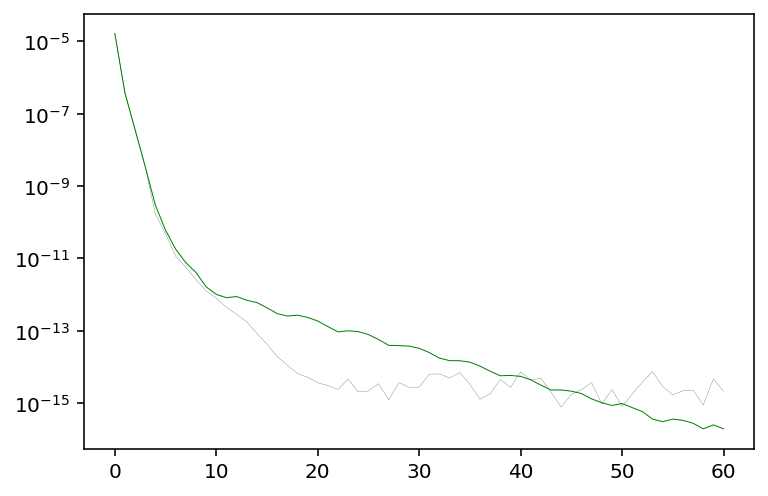

In [35]:
plt.yscale("log")
plt.plot(Bad_trajectories_aa[:, 0], color="black", linewidth=0.1)
plt.plot(Bad_trajectories_sdc[:, 0], color="green", linewidth=0.5);

## Nonstiff Van der Pol 

Pictures are nicer but AA is completely useless and SDC is extremely efficient. No need to speed-up SDC in this situation.

In [36]:
eps = 10.0

N_points, N_intervals, N_sweeps, N_aa = 2**5 + 1, 200, 30, 10
T = [0, 40]

u0 = jnp.array([-1.0, 2.0])

@jit
def F(u, t, epsilon=eps):
    return jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1)

@jit
def inv_dF(u, u_F, t, h, epsilon=eps, t1=T[1]/N_intervals, t0=T[0]):
    h_ = h*(t1 - t0)/2
    det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
    u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
    u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
    return jnp.stack([u0, u1], -1)

In [37]:
Euler, Sol, Time, Res_sdc, Res_aa = generate_dataset.generate_trajectory(u0, F, inv_dF, T, N_points, N_intervals, N_sweeps, N_aa)

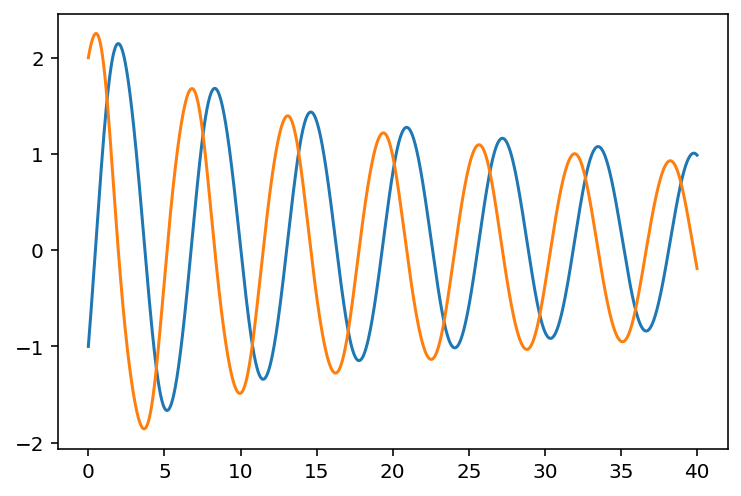

In [38]:
S, T = generate_dataset.recompute_on_uniform_grid(Sol, Time)
solution, time = generate_dataset.glue_trajectory(S, T)
plt.plot(time, solution);

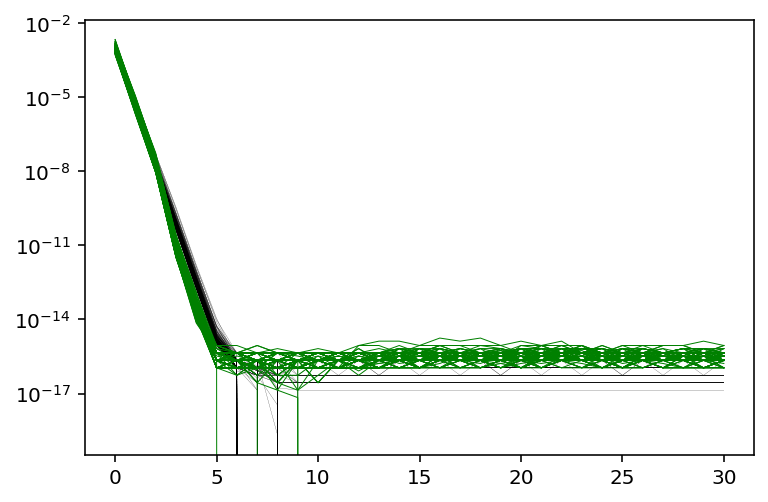

In [39]:
plt.yscale("log")
plt.plot(Res_sdc, color="black", linewidth=0.1)
plt.plot(Res_aa, color="green", linewidth=0.5);

# Two-body problem

In $D=2$ two-body problem reads

\begin{equation}
    \begin{split}
        &\alpha = \frac{G m_1 m_2}{\left(\left(x_1^2 - x_2^2\right)^2 + \left(y_1^2 - y_2^2\right)^2\right)^{\frac{3}{2}}},\\
        &\beta = (x_2 - x_1)\alpha,\,\gamma = (y_2 - y_1)\alpha;\\
        &\dot{\vec{v}}_{1} = \frac{1}{m_1}\begin{pmatrix}\beta & \gamma\end{pmatrix},\,\frac{d}{dt}\begin{pmatrix}x_1 & y_1\end{pmatrix} = \vec{v}_1;\\
        &\dot{\vec{v}}_{2} = -\frac{1}{m_2}\begin{pmatrix}\beta & \gamma\end{pmatrix},\,\frac{d}{dt}\begin{pmatrix}x_2 & y_2\end{pmatrix} = \vec{v}_2.
    \end{split}
\end{equation}

In [40]:
@jit
def F(u, t, m1=2, m2=2, G=1):
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = u
    beta, gamma = x2 - x1, y2 - y1
    alpha = G*m1*m2 / (beta**2 + gamma**2)**(3/2)
    beta, gamma = alpha*beta, alpha*gamma
    F = [vx1, vy1, vx2, vy2, beta/m1, gamma/m1, -beta/m2, -gamma/m2]
    return jnp.stack(F, -1)

N_points, N_intervals, N_sweeps, N_aa = 2**5 + 1, 100, 40, 10
T = [0, 100]

In [41]:
u0 = jnp.array([-5, 0, 5, 0, 0, 0.2, 0, -0.4])
Euler, Sol, Time, Res_sdc, Res_aa = generate_dataset.generate_trajectory(u0, F, None, T, N_points, N_intervals, N_sweeps, N_aa)

In [42]:
S_, T_ = generate_dataset.recompute_on_uniform_grid(Sol, Time)
solution, time = generate_dataset.glue_trajectory(S_, T_)

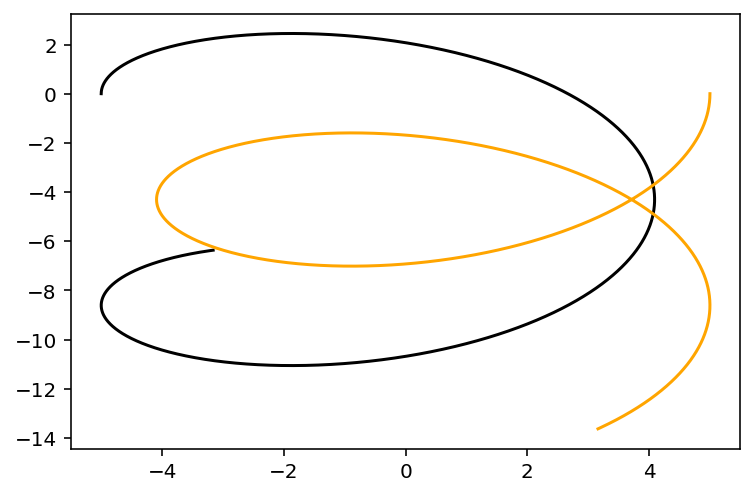

In [43]:
plt.plot(solution[:, 0], solution[:, 1], color="black")
plt.plot(solution[:, 2], solution[:, 3], color="orange");